# Duke PAM Project - Undersampled PAM
## Title: Main Training Document
## Author: Anthony DiSpirito III
## Github: @axd465
## Date: November 20, 2020

### pip installs/uninstalls

In [1]:
# !pip3 uninstall tensorflow_datasets -y -q
# !pip3 install git+git://github.com/axd465/datasets -q

### Import Statements

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os
import shutil
from functools import partial
from tensorflow.image import random_crop, random_brightness, random_contrast, \
                             random_flip_left_right, random_flip_up_down, resize
if os.path.basename(os.getcwd()) == 'future_work':
    os.chdir('../')
from utils.model_utils import SSIM
from utils.model_utils import PSNR
from utils.downsampling_utils import *
from utils.augmentation_utils import *

%matplotlib inline
%load_ext autoreload
%autoreload 2
AUTOTUNE = os.cpu_count()//2 #tf.data.experimental.AUTOTUNE
print('Tensorflow version: ' + tf.__version__)

Tensorflow version: 2.3.1


In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Load Dataset

In [7]:
(train_ds, val_ds), metadata = tfds.load('duke_pam/clean', split=['train', 'validation'], with_info=True, data_dir = 'data')

## Model Training

### Setting Training Parameters

In [8]:
DOWNSAMPLING_METHOD = 'uniform' # 'uniform' or 'random'
SPARSITY = 1 - (1/9)
DOWN_RATIO = (3,3)

In [9]:
CROP_SIZE = (128, 128, 3)
rand_crop = partial(random_crop, size = CROP_SIZE)

In [10]:
PROB_OF_AUG = 1/3 # prob [0,1]
MAX_BRIGHT_SHIFT = 0.1 # in range [0,1]
LOWER_CONTRAST_FACTOR = 0.2
UPPER_CONTRAST_FACTOR = 1.8
GAUSS_NOISE_MEAN = 0
LOWER_GAUSS_NOISE_STD = 0.003
UPPER_GAUSS_NOISE_STD = 0.015
main_augment = partial(augment, prob = PROB_OF_AUG, max_shift = MAX_BRIGHT_SHIFT, 
                       lower_con_factor = LOWER_CONTRAST_FACTOR, upper_con_factor = UPPER_CONTRAST_FACTOR,
                       mean = GAUSS_NOISE_MEAN, std_lower = LOWER_GAUSS_NOISE_STD, 
                       std_upper = UPPER_GAUSS_NOISE_STD)

In [11]:
MAX_SHIFT_FRACTION_X_Y = [0.1, 0.1]
FILL_MODE = 'constant'
INTERP_ORD = 0 # No Interp

lambda_map_func = partial(keras_augment, fill_mode=FILL_MODE, interpolation_order=INTERP_ORD, 
                  max_width_shift = MAX_SHIFT_FRACTION_X_Y[0], max_height_shift = MAX_SHIFT_FRACTION_X_Y[1])
lambda_func = lambda x: tf.numpy_function(lambda_map_func, [x], tf.float32)

### Picking Downsampling Method

In [12]:
if DOWNSAMPLING_METHOD is 'random':
    down_map_func = partial(downsample_zerofill, sparsity=SPARSITY, min_shape = (CROP_SIZE[0], CROP_SIZE[1]))
    train_ds_down_zerofill_rand = train_ds.map(lambda x: tf.numpy_function(down_map_func, [x['image']], tf.float32), num_parallel_calls=AUTOTUNE).cache()
    val_ds_down_zerofill_rand = val_ds.map(lambda x: tf.numpy_function(down_map_func, [x['image']], tf.float32), num_parallel_calls=AUTOTUNE).cache()
    
    train_ds_aug_rand = (
        train_ds_down_zerofill_rand
        .map(rand_crop, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
        .map(main_augment, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
        .map(lambda_func, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )
    val_ds_aug_rand = (
        val_ds_down_zerofill_rand
        .map(rand_crop, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    ) 
else:
    down_map_func = partial(downsample_zerofill, down_ratio=DOWN_RATIO, min_shape = (CROP_SIZE[0], CROP_SIZE[1]))
    train_ds_down_zerofill = train_ds.map(lambda x: tf.numpy_function(down_map_func, [x['image']], tf.float32), num_parallel_calls=AUTOTUNE).cache()
    val_ds_down_zerofill = val_ds.map(lambda x: tf.numpy_function(down_map_func, [x['image']], tf.float32), num_parallel_calls=AUTOTUNE).cache()
    
    train_ds_aug = (
        train_ds_down_zerofill
        .map(rand_crop, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
        .map(main_augment, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
        .map(lambda_func, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    )
    val_ds_aug = (
        val_ds_down_zerofill
        .map(rand_crop, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    ) 

### Shuffling Data and Batching

In [13]:
def custom_generator_wrapper(gen):
    '''
    This wrapper function ensures that the downsampled data and ground truth
    stay coaligned during the random crop step.
    '''
    for data in gen:
        orig_img = data[...,0] # target
        down_img = data[...,1] # input
        # mask_img = data[...,2] # mask
        yield down_img[..., None], orig_img[..., None]

In [14]:
# Import Model:
from models.UNet import getModel
# from models.UNet_ModPlusPlus import getModel

In [15]:
# Hyperparameters:
FRESH_GEN_MODEL = True
STANDARD_IMAGE_SHAPE = (None, None, 1)
BATCH_SIZE = 16
EPOCHS = 100
FILTERS = 64
INITIAL_LR = 0.005
ACTIVATION = 'elu'       
KERNEL_SIZE = 3 # 3x3 kernel
AUGMENTATIONS = 10
VAL_AUGMENTATIONS = 10
MODEL_DIR = 'saved_models'
BUFFER_SIZE = 10000
NUM_TRAIN = metadata.splits['train'].num_examples
NUM_VAL = metadata.splits['validation'].num_examples
UPDATE_INFO_EVERY_X_EPOCHS = 22
delete_previous = True
SAVE_METRIC = 'val_SSIM'

In [16]:
if DOWNSAMPLING_METHOD is 'uniform':
    train_ds_aug_batch = train_ds_aug.prefetch(AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)
    val_ds_aug_batch = val_ds_aug.prefetch(AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)
else:
    train_ds_aug_batch = train_ds_aug_rand.prefetch(AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)
    val_ds_aug_batch = val_ds_aug_rand.prefetch(AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)

## Load Model or Use Fresh Model

In [17]:
if FRESH_GEN_MODEL:
    print('Getting Fresh Model...')
    model = getModel(input_shape=STANDARD_IMAGE_SHAPE, filters=FILTERS, kernel_size=KERNEL_SIZE, activation=ACTIVATION)
    print('Done!!!')
else:
    if DOWNSAMPLING_METHOD is 'random':
        input_dir = f'saved_unet_rand_down_{int(np.round(SPARSITY*100))}p'
    else:
        input_dir = f'saved_unet_uni_down_{DOWN_RATIO[0]}_{DOWN_RATIO[1]}'
    best_model_dir = os.path.join(input_dir, 'best_models')
    file_list = [file for file in os.listdir(best_model_dir) if os.path.isfile(os.path.join(best_model_dir, file))]
    filename = sorted(file_list, key = lambda x : int(x.partition('h_')[2].partition('-')[0]))[-1]
    path = os.path.join(best_model_dir, filename)
    print('Loading Model...')
    model = tf.keras.models.load_model(path, custom_objects={'SSIM':SSIM, 'PSNR':PSNR})
    print('Done!!!')

Getting Fresh Model...
Done!!!


In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR, amsgrad=False),  # pick an optimizer
              loss='mean_absolute_error',
              experimental_steps_per_execution = ((AUGMENTATIONS)*np.ceil(NUM_TRAIN/BATCH_SIZE))//UPDATE_INFO_EVERY_X_EPOCHS,
              metrics=['mean_absolute_error', 'mean_squared_error', SSIM, PSNR])

## GAN Testing

In [19]:
## Discriminator Hyperparameters:
FILTERS = 64
ALPHA = 0.1
DROP_PROB = 0.2

In [21]:
## Discriminator:
inputs_d = tf.keras.Input(shape=(128, 128, 1)) # Discriminator Model
x_d = inputs_d
x_d = tf.keras.layers.Conv2D(FILTERS, 3, strides=1, padding='same')(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=ALPHA)(x_d)

x_d = tf.keras.layers.Conv2D(FILTERS, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=ALPHA)(x_d)
x_d = tf.keras.layers.SpatialDropout2D(DROP_PROB)(x_d)

x_d = tf.keras.layers.Conv2D(2*FILTERS, 3, strides=1, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=ALPHA)(x_d)

x_d = tf.keras.layers.Conv2D(2*FILTERS, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=ALPHA)(x_d)
x_d = tf.keras.layers.SpatialDropout2D(DROP_PROB)(x_d)

x_d = tf.keras.layers.Conv2D(2*2*FILTERS, 3, strides=1, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=ALPHA)(x_d)

x_d = tf.keras.layers.Conv2D(2*2*FILTERS, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=ALPHA)(x_d)
x_d = tf.keras.layers.SpatialDropout2D(DROP_PROB)(x_d)

x_d = tf.keras.layers.Conv2D(2*2*2*FILTERS, 3, strides=1, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=ALPHA)(x_d)

x_d = tf.keras.layers.Conv2D(2*2*2*FILTERS, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.BatchNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=ALPHA)(x_d)
x_d = tf.keras.layers.SpatialDropout2D(DROP_PROB)(x_d)

x_d = tf.keras.layers.Flatten()(x_d)
x_d = tf.keras.layers.Dense(1024)(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=ALPHA)(x_d)
x_d = tf.keras.layers.Dropout(DROP_PROB)(x_d)
x_d = tf.keras.layers.Dense(128)(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=ALPHA)(x_d)
x_d = tf.keras.layers.Dropout(DROP_PROB//2)(x_d)
x_d = tf.keras.layers.Dense(1, activation='sigmoid')(x_d)
x_d = tf.keras.layers.Dense(1)(x_d)

output_d = x_d
model_d = tf.keras.Model(inputs_d, output_d, name='discriminator')
model_d.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_26 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
spatial_dropout2d_4 (Spatial (None, 64, 64, 64)      

In [24]:
# Import Model:
from models.GAN import getModel
gan_model = getModel(model_d, model, discriminator_extra_steps=3)

In [27]:
EPOCHS = 10

In [28]:
gan_model.compile(tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9), 
                  tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9), 
                  lambda y,x: tf.reduce_mean(tf.keras.losses.binary_crossentropy(y,x)), 
                  lambda y,x: tf.reduce_mean(tf.keras.losses.mean_absolute_error(y,x)),
                  loss_weights = [0.1, 0.1, 10],
                  experimental_steps_per_execution = ((AUGMENTATIONS)*np.ceil(NUM_TRAIN/BATCH_SIZE))//UPDATE_INFO_EVERY_X_EPOCHS,
                  metrics=['mean_absolute_error', 'mean_squared_error', SSIM, PSNR])

In [29]:
if not os.path.exists(MODEL_DIR):
            os.mkdir(MODEL_DIR)
elif delete_previous:
            shutil.rmtree(MODEL_DIR)
            os.mkdir(MODEL_DIR)
            
custom_callback = tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(MODEL_DIR, 'saved_model.epoch_{epoch:02d}-' + 
                                                                           SAVE_METRIC + '_{' + SAVE_METRIC + ':.5f}.h5'),
                                                     monitor='val_SSIM',
                                                     verbose=0, 
                                                     save_best_only=True, save_weights_only=False, 
                                                     mode='max', save_freq='epoch')
custom_callback.set_model(gan_model.generator)

In [30]:
history = gan_model.fit(custom_generator_wrapper(train_ds_aug_batch),
                        steps_per_epoch=AUGMENTATIONS*np.ceil(NUM_TRAIN/BATCH_SIZE),
                        epochs=EPOCHS,
                        callbacks=[custom_callback],
                        validation_data=custom_generator_wrapper(val_ds_aug_batch),
                        validation_steps=VAL_AUGMENTATIONS*np.ceil(NUM_TRAIN/BATCH_SIZE), 
                        max_queue_size=AUGMENTATIONS*np.ceil(NUM_TRAIN/BATCH_SIZE))

Epoch 1/10
220/220 [==============================] - 111s 505ms/step - mean_absolute_error: 0.1421 - mean_squared_error: 0.2281 - SSIM: 0.4698 - PSNR: 17.8026 - d_loss: 0.5718 - g_loss: 13.7910 - recon_loss: 0.1423 - val_loss: 0.0000e+00 - val_mean_absolute_error: 0.0552 - val_mean_squared_error: 0.0085 - val_SSIM: 0.5585 - val_PSNR: 21.3737 - val_d_loss: 0.0000e+00 - val_g_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00
Epoch 2/10
220/220 [==============================] - 107s 485ms/step - mean_absolute_error: 0.1447 - mean_squared_error: 0.2437 - SSIM: 0.5110 - PSNR: 18.4520 - d_loss: 0.7244 - g_loss: 15.2493 - recon_loss: 0.1452 - val_loss: 0.0000e+00 - val_mean_absolute_error: 0.1061 - val_mean_squared_error: 0.0264 - val_SSIM: 0.4915 - val_PSNR: 17.8168 - val_d_loss: 0.0000e+00 - val_g_loss: 0.0000e+00 - val_recon_loss: 0.0000e+00
Epoch 3/10
220/220 [==============================] - 108s 489ms/step - mean_absolute_error: 0.1461 - mean_squared_error: 0.1508 - SSIM: 0.5173 - PSNR: 

(500, 850, 3)
(512, 864, 3)
(500, 850, 1)


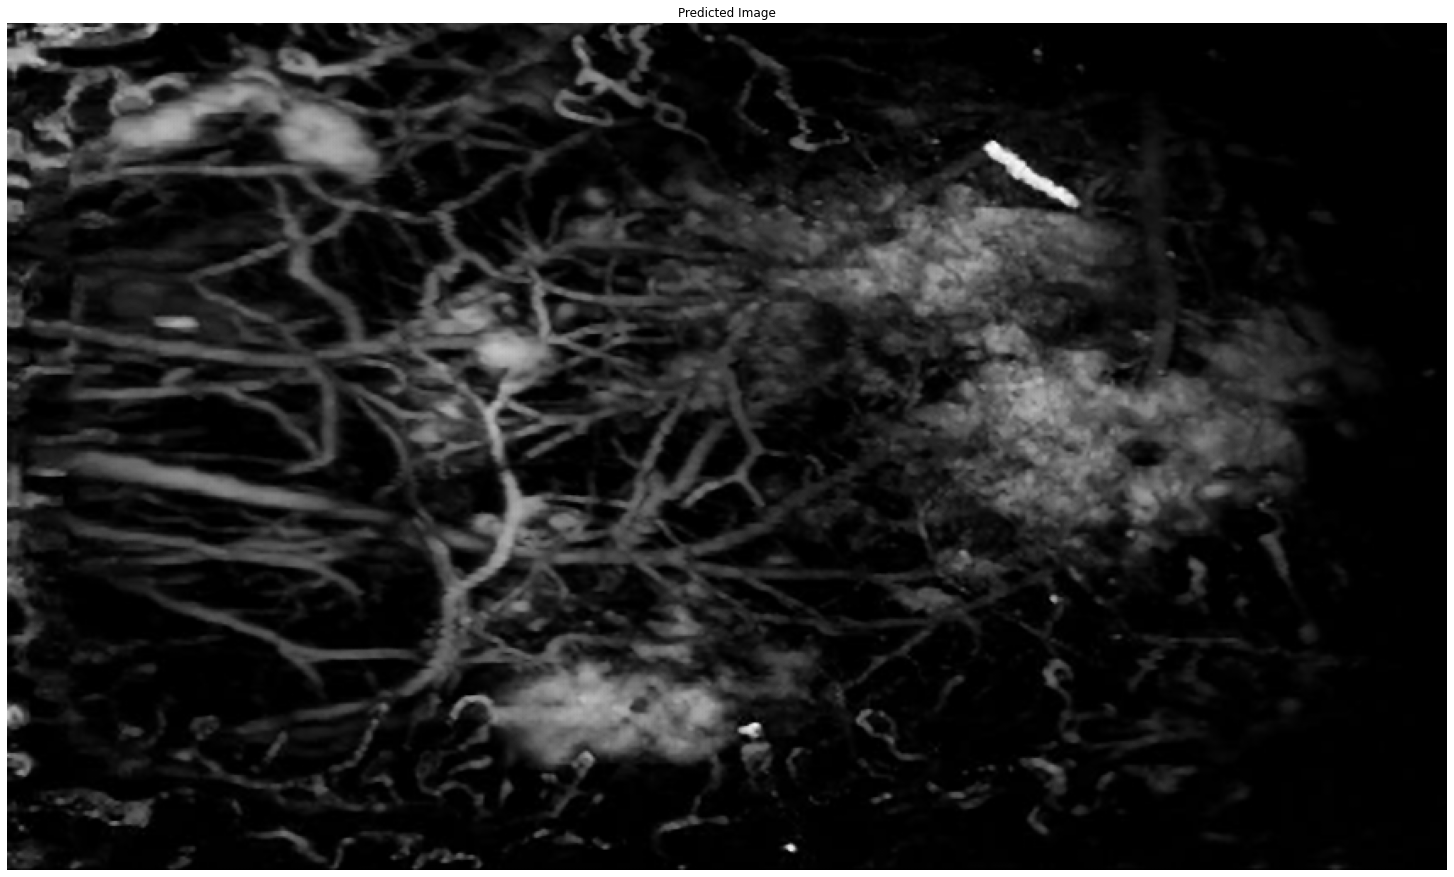

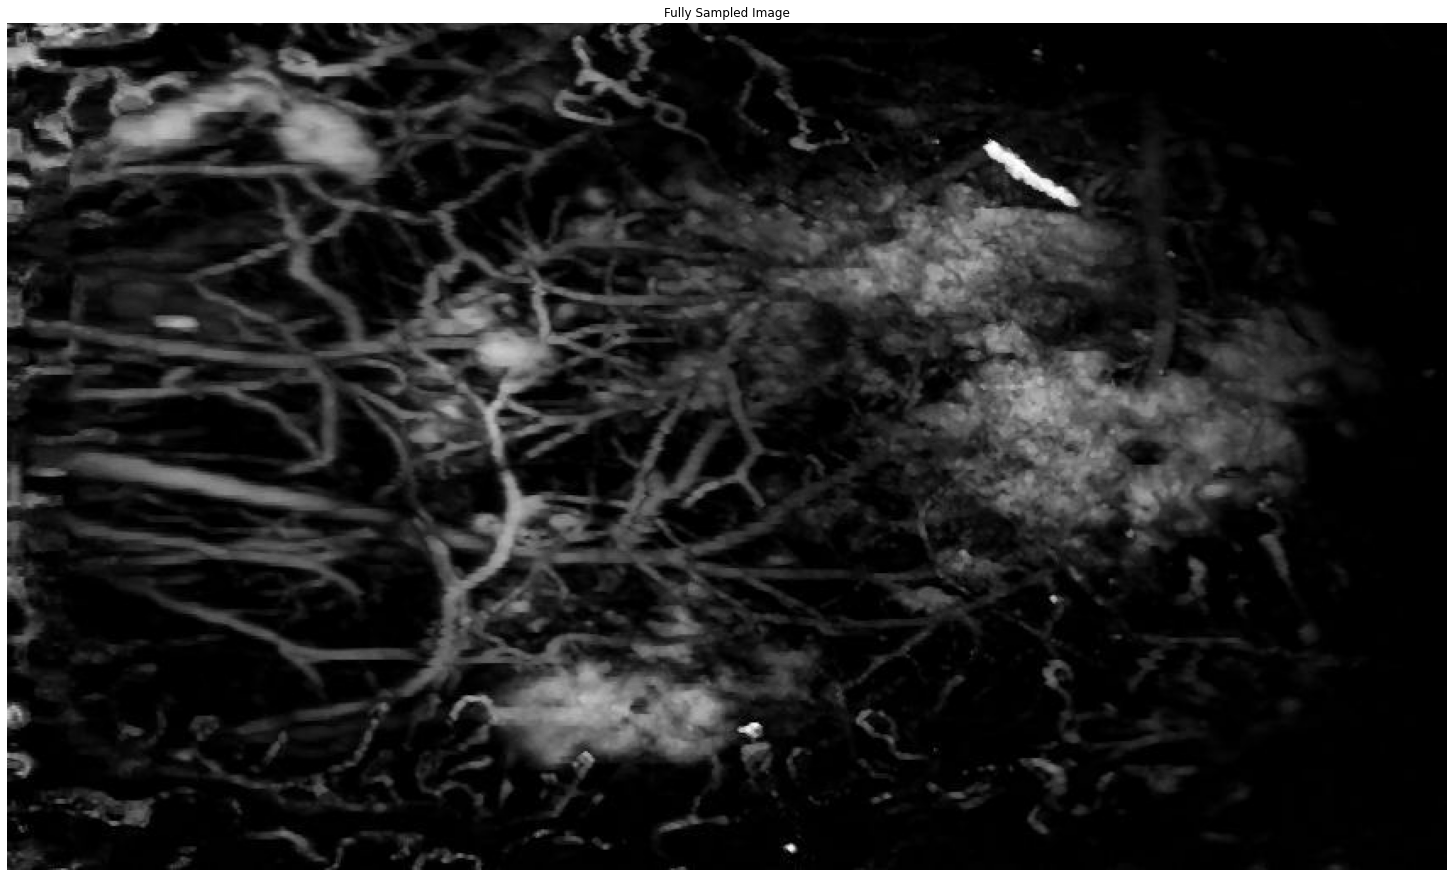

In [105]:
img = next(iter(train_ds_down_zerofill.shuffle(10000)))


print(img.shape)
orig_img = tf.pad(img, [[0, (np.ceil(img.shape[0]/32)*32 - img.shape[0]).astype(np.int32)], 
                        [0, (np.ceil(img.shape[1]/32)*32 - img.shape[1]).astype(np.int32)], 
                        [0,0]], "CONSTANT")
print(orig_img.shape)
pred = gan_model.predict(orig_img[...,1][None,...,None])[0,...]
pred = tf.image.crop_to_bounding_box(pred, 0, 0, img.shape[0], img.shape[1])
orig_img = tf.image.crop_to_bounding_box(orig_img, 0, 0, img.shape[0], img.shape[1])
figsize = (20,20)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(pred, cmap = 'gray')
plt.title('Predicted Image')
plt.show()
figsize = (20,20)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(orig_img[...,0], cmap = 'gray')
plt.title('Fully Sampled Image')
plt.show()